In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [6]:
df_train = pd.read_csv("gs://aura_datasets_training_validation/AURA_aug_sep_60k.csv")
df_val = pd.read_csv("gs://aura_datasets_training_validation/AURA_validation_sep_12k.csv")

In [ ]:
df_train.head()

,timestamp,location_type,context,noise_db,light_lux,crowd_count,discomfort_level,comfort_label
0,2025-09-23T00:44,outdoor,forest,36.4,120,0,0.196,very_comfortable
1,2025-09-28T00:40,outdoor,square,70.8,173,15,0.575,neutral
2,2025-09-22T03:07,outdoor,garden,34.6,120,0,0.187,very_comfortable
3,2025-09-24T17:35,outdoor,bus_stop,68.8,797,16,0.732,uncomfortable
4,2025-09-22T02:02,indoor,library,30.4,223,0,0.194,very_comfortable


In [8]:
df_val.head()

,timestamp,location_type,context,noise_db,light_lux,crowd_count,discomfort_level,comfort_label
0,2025-09-23T00:44,outdoor,forest,36.4,120,0,0.196,very_comfortable
1,2025-09-28T00:40,outdoor,square,70.8,173,15,0.575,neutral
2,2025-09-22T03:07,outdoor,garden,34.6,120,0,0.187,very_comfortable
3,2025-09-24T17:35,outdoor,bus_stop,68.8,797,16,0.732,uncomfortable
4,2025-09-22T02:02,indoor,library,30.4,223,0,0.194,very_comfortable


In [10]:
X = df_train[["noise_db", "light_lux", "crowd_count"]]
y = df_train["comfort_label"]

## Splitting Data

## Preprocessing

In [14]:
# Label encode the comfort_label
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y)
y_encoded = le.transform(y)

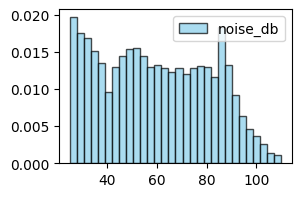

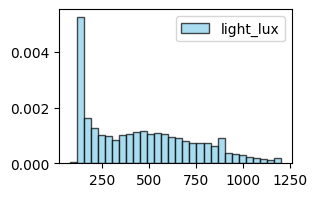

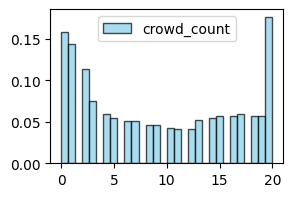

In [23]:
# Check for distribution in X to decide on scaler
cols = ['noise_db', 'light_lux', 'crowd_count']

for c in cols:
    data = X[c].dropna()
    plt.figure(figsize=(3,2))
    # Histogram
    plt.hist(data, bins=30, color='skyblue', edgecolor='black', alpha=0.7, density=True, label=c)
    plt.legend()

In [ ]:
# Scaling: Noise - min-max; Brightness - left skewed - np.log1p() then StandardScaler; Crowd - min-max